In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual log filename if different
logfile = 'encoder_log_20250607_185816.csv' 

# Load the data
df = pd.read_csv(logfile)

# Show the first few rows
df.head()

,ros_time,ticks_L,ticks_R,ticks_UNUSED,delta_ticks_L,delta_ticks_R,delta_ticks_UNUSED,delta_time_usec
0,1.749337e+09,235560,-344893,0,0,0,0,40480
1,1.749337e+09,235560,-344893,0,0,0,0,40284
2,1.749337e+09,235560,-344893,0,0,0,0,40290
3,1.749337e+09,235560,-344893,0,0,0,0,40296
4,1.749337e+09,235560,-344893,0,0,0,0,41087


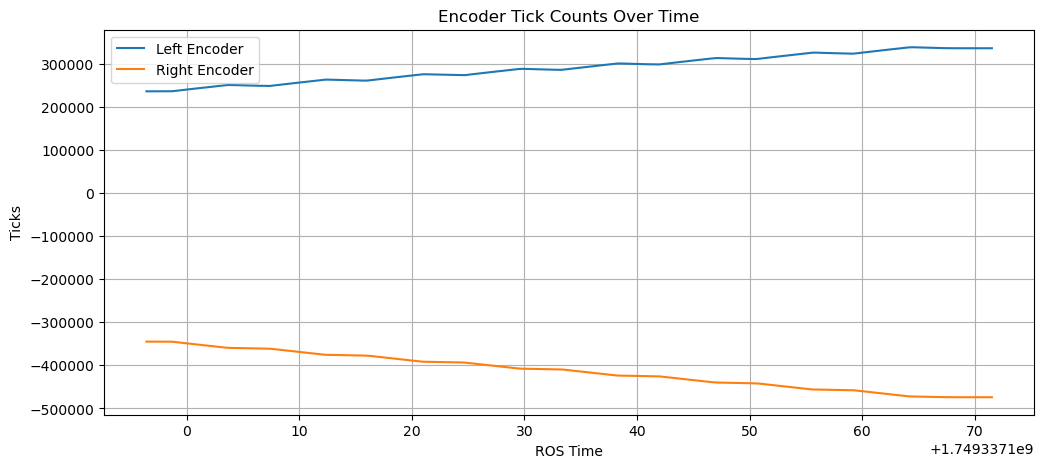

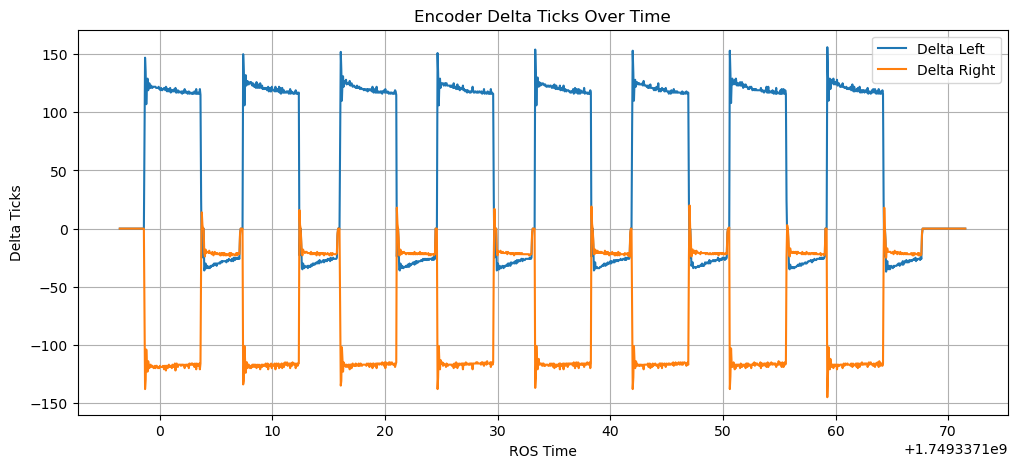

In [18]:
# Plot left and right encoder tick counts over time
plt.figure(figsize=(12, 5))
plt.plot(df['ros_time'], df['ticks_L'], label='Left Encoder')
plt.plot(df['ros_time'], df['ticks_R'], label='Right Encoder')
plt.xlabel('ROS Time')
plt.ylabel('Ticks')
plt.title('Encoder Tick Counts Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot left and right delta ticks over time
plt.figure(figsize=(12, 5))
plt.plot(df['ros_time'], df['delta_ticks_L'], label='Delta Left')
plt.plot(df['ros_time'], df['delta_ticks_R'], label='Delta Right')
plt.xlabel('ROS Time')
plt.ylabel('Delta Ticks')
plt.title('Encoder Delta Ticks Over Time')
plt.legend()
plt.grid(True)
plt.show()

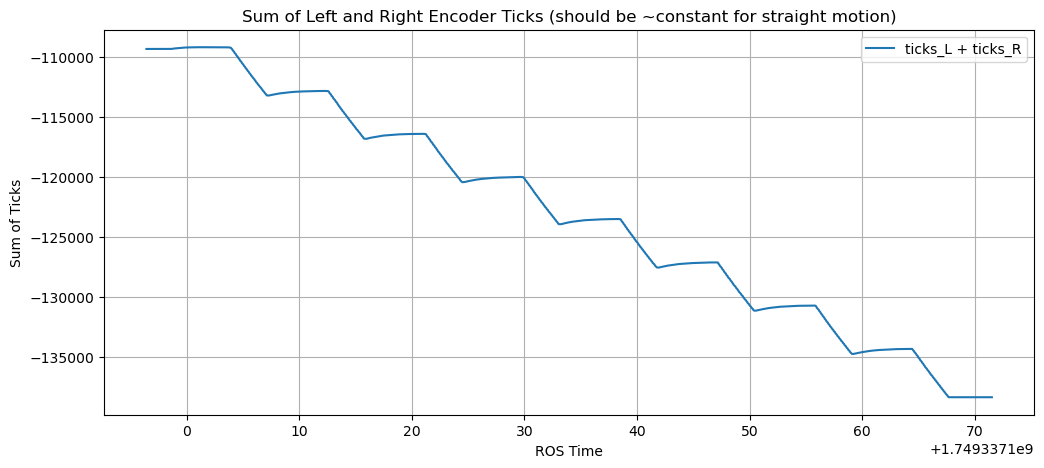

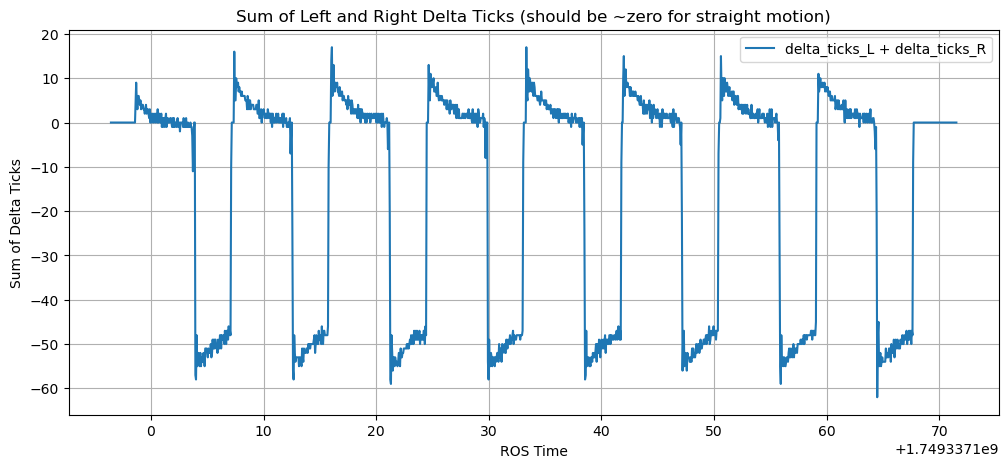

In [19]:
# Plot the sum of left and right ticks (should be ~constant if both are counting equally)
plt.figure(figsize=(12, 5))
plt.plot(df['ros_time'], df['ticks_L'] + df['ticks_R'], label='ticks_L + ticks_R')
plt.xlabel('ROS Time')
plt.ylabel('Sum of Ticks')
plt.title('Sum of Left and Right Encoder Ticks (should be ~constant for straight motion)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the sum of delta ticks
plt.figure(figsize=(12, 5))
plt.plot(df['ros_time'], df['delta_ticks_L'] + df['delta_ticks_R'], label='delta_ticks_L + delta_ticks_R')
plt.xlabel('ROS Time')
plt.ylabel('Sum of Delta Ticks')
plt.title('Sum of Left and Right Delta Ticks (should be ~zero for straight motion)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate error for all data (no filtering)
df['sum_error'] = df['delta_ticks_L'] + df['delta_ticks_R']

# Compute statistics
mean_abs_error = df['sum_error'].abs().mean()
max_abs_error = df['sum_error'].abs().max()

print(f'Mean absolute error: {mean_abs_error:.2f} ticks')
print(f'Max absolute error: {max_abs_error:.2f} ticks')


Mean absolute error: 19.13 ticks
Max absolute error: 62.00 ticks


In [21]:
straight = df[
    (df['delta_ticks_L'] > 0) & (df['delta_ticks_R'] < 0)
].copy()
straight['sum_error'] = straight['delta_ticks_L'] + straight['delta_ticks_R']

mean_abs_error = straight['sum_error'].abs().mean()
max_abs_error = straight['sum_error'].abs().max()

print(f'Mean absolute error (straight): {mean_abs_error:.2f} ticks')
print(f'Max absolute error (straight): {max_abs_error:.2f} ticks')


Mean absolute error (straight): 3.19 ticks
Max absolute error (straight): 17.00 ticks


In [23]:
# Filter for straight motion (left > 0, right < 0)
straight = df[(df['delta_ticks_L'] > 0) & (df['delta_ticks_R'] < 0)].copy()

# Mean absolute value of delta_ticks (use left, or average of abs(left) and abs(right))
mean_delta = (straight['delta_ticks_L'].abs().mean() + straight['delta_ticks_R'].abs().mean()) / 2

# Max absolute difference
max_diff = (straight['delta_ticks_L'] - (-straight['delta_ticks_R'])).abs().max()

# Percentage
percent = 100 * max_diff / mean_delta if mean_delta != 0 else float('nan')

print(f'Mean abs(delta_ticks): {mean_delta:.2f}')
print(f'Max abs difference: {max_diff:.2f}')
print(f'Max difference as percent of mean: {percent:.2f}%')


Mean abs(delta_ticks): 118.03
Max abs difference: 17.00
Max difference as percent of mean: 14.40%


In [24]:
diff = (straight['delta_ticks_L'] - (-straight['delta_ticks_R'])).abs()
over_10pct = (diff > 0.1 * mean_delta).sum()
total = len(diff)
print(f"Number of samples with >10% difference: {over_10pct} out of {total} ({100*over_10pct/total:.1f}%)")

Number of samples with >10% difference: 10 out of 747 (1.3%)
